In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Install gdown
try:
    import gdown
except ImportError:
    !pip install -q gdown
    import gdown

# Reproducibility
SEED = 42
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(SEED)

print(f"TensorFlow Version: {tf.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

TensorFlow Version: 2.19.0
GPU is NOT available


**1: DATA LOADING & AUGMENTATION**

In [ ]:
# Download Dataset
GDRIVE_URL = "https://drive.google.com/uc?id=1w3_8BXnWNAK5sF0T1u3Bu63pueVkBpcU"
ZIP_NAME = "dataset.zip"
DATA_DIR = "dataset"
AUG_DIR = "augmented_dataset"

if not os.path.exists(DATA_DIR):
    print("Downloading dataset...")
    gdown.download(GDRIVE_URL, ZIP_NAME, quiet=False)

    print("Extracting...")
    with zipfile.ZipFile(ZIP_NAME, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print("Extraction complete.")
else:
    print("Dataset already exists.")

# Ensure augmentation directory exists
os.makedirs(AUG_DIR, exist_ok=True)

# Initial Data Scan
ROOT_PATH = os.path.join(DATA_DIR, "images")
if not os.path.exists(ROOT_PATH):
    ROOT_PATH = DATA_DIR

filepaths = []
labels = []

# Walk through directories
for class_folder in os.listdir(ROOT_PATH):
    class_path = os.path.join(ROOT_PATH, class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                filepaths.append(os.path.join(class_path, img_file))
                labels.append(class_folder)

# Create Initial DataFrame
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# BALANCE RARE CLASSES, we augment classes with < 5 images to reach 5.
TARGET_COUNT = 5
class_counts = df['label'].value_counts()
rare_classes = class_counts[class_counts < TARGET_COUNT].index

print(f"\nFound {len(rare_classes)} rare classes (count < {TARGET_COUNT}). Augmenting them now...")

# generator for offline augmentation
aug_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

new_filepaths = []
new_labels = []

for cls in rare_classes:
    current_count = class_counts[cls]
    needed = TARGET_COUNT - current_count

    # Get existing images for this class
    existing_files = df[df['label'] == cls]['filepath'].values

    print(f"  -> Augmenting class '{cls}': {current_count} existing, creating {needed} new.")

    # Generate needed images
    for i in range(needed):
        # Pick a random source image from the class
        src_path = np.random.choice(existing_files)

        # Load and convert
        img = load_img(src_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape) # Reshape to (1, H, W, C)

        # Generate 1 augmented image
        for batch in aug_datagen.flow(x, batch_size=1):
            aug_img = array_to_img(batch[0])

            # Save to disk (so we can load it later normally)
            save_name = f"{cls}_aug_{i}.jpg"
            save_path = os.path.join(AUG_DIR, save_name)
            aug_img.save(save_path)

            # Add to lists
            new_filepaths.append(save_path)
            new_labels.append(cls)
            break # Stop the generator loop (we only want 1 image per 'needed' iteration)

# Add augmented data to main lists
filepaths.extend(new_filepaths)
labels.extend(new_labels)

# Re-create DataFrame with ALL data
df_final = pd.DataFrame({'filepath': filepaths, 'label': labels})

print(f"\nOriginal Samples: {len(df)}")
print(f"Final Samples:    {len(df_final)} (All classes now have >= {TARGET_COUNT} images)")
print(f"Number of Classes: {df_final['label'].nunique()}")

Downloading...
From (original): https://drive.google.com/uc?id=1w3_8BXnWNAK5sF0T1u3Bu63pueVkBpcU
From (redirected): https://drive.google.com/uc?id=1w3_8BXnWNAK5sF0T1u3Bu63pueVkBpcU&confirm=t&uuid=ea9b6900-44d8-4efc-bd8b-c1c3c8faa4e2
To: /content/dataset.zip
100%|██████████| 60.7M/60.7M [00:01<00:00, 52.2MB/s]


Extracting...
Extraction complete.

Found 809 rare classes (count < 5). Augmenting them now...
  -> Augmenting class 'Scyther': 4 existing, creating 1 new.
  -> Augmenting class 'Exeggcute': 4 existing, creating 1 new.
  -> Augmenting class 'Entei': 4 existing, creating 1 new.
  -> Augmenting class 'Altaria': 4 existing, creating 1 new.
  -> Augmenting class 'Pidgey': 4 existing, creating 1 new.
  -> Augmenting class 'Aggron': 4 existing, creating 1 new.
  -> Augmenting class 'Lickitung': 4 existing, creating 1 new.
  -> Augmenting class 'Abra': 4 existing, creating 1 new.
  -> Augmenting class 'Oddish': 4 existing, creating 1 new.
  -> Augmenting class 'Cubone': 4 existing, creating 1 new.
  -> Augmenting class 'Camerupt': 4 existing, creating 1 new.
  -> Augmenting class 'Rhyhorn': 4 existing, creating 1 new.
  -> Augmenting class 'Voltorb': 4 existing, creating 1 new.
  -> Augmenting class 'Pidgeotto': 4 existing, creating 1 new.
  -> Augmenting class 'Magmar': 4 existing, creating 

**2: PREPROCESSING & SPLIT**

In [ ]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Get the total number of unique classes
num_classes = df_final['label'].nunique()

# 2.2 Split Data (Stratified)

# First split: df_final into (train + val) and test
# Ensure test_df has at least num_classes samples
train_val_df, test_df = train_test_split(
    df_final, test_size=num_classes, stratify=df_final['label'], random_state=SEED
)

# Second split: (train + val) into train_df and val_df
# Ensure val_df has at least num_classes samples
train_df, val_df = train_test_split(
    train_val_df, test_size=num_classes, stratify=train_val_df['label'], random_state=SEED
)

print(f"Train size: {len(train_df)}")
print(f"Val size:   {len(val_df)}")
print(f"Test size:  {len(test_df)}")

# Image Enhancement Function (CLAHE)
def apply_preprocessing(img):
    if img.dtype != 'uint8':
        img = (img).astype('uint8')
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return preprocess_input(final)

# Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=apply_preprocessing,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=apply_preprocessing
)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=SEED
)

val_gen = test_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# Class Weights
class_indices = train_gen.class_indices
class_weights_arr = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(class_weights_arr))

Train size: 2749
Val size:   898
Test size:  898
Found 2749 validated image filenames belonging to 898 classes.
Found 898 validated image filenames belonging to 898 classes.
Found 898 validated image filenames belonging to 898 classes.


**3: MODEL CONSTRUCTION**

In [ ]:
def build_model(num_classes):
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet_Custom")
    return base_model, model

base_model, model = build_model(len(class_indices))
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "EfficientNet_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 898)            │       230,786 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,614,437 (17.60 MB)

 Trainable params: 561,794 (2.14 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

**4: TRAINING The Model**

In [ ]:
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss', mode='min')
early_stop_cb = EarlyStopping(patience=6, monitor='val_loss', restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss', min_lr=1e-6)

# Phase 1: Train Head
print("\n Phase 1: Training Head")
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model.fit(
    train_gen, validation_data=val_gen, epochs=15,
    class_weight=class_weights_dict, callbacks=[checkpoint_cb, reduce_lr_cb]
)

# Phase 2: Fine-Tuning
print("\n Phase 2: Fine-Tuning Base")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = model.fit(
    train_gen, validation_data=val_gen, epochs=15,
    class_weight=class_weights_dict, callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb]
)


 Phase 1: Training Head


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0031 - loss: 6.9164

**5: Model EVALUATION**

In [ ]:
model.load_weights("best_model.keras")
print("\n Best model loaded.")

test_gen.reset()
preds = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(preds, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print("\n Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(16, 14)) # Increased size for readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 74 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Best model loaded.
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step

Classification Report:
              precision    recall  f1-score   support

   Abomasnow       0.00      0.00      0.00         1
        Abra       0.00      0.00      0.00         1
       Absol       1.00      1.00      1.00         1
    Accelgor       0.50      1.00      0.67         1
   Aegislash       0.00      0.00      0.00         1
  Aerodactyl       0.50      1.00      0.67         1
      Aggron       1.00      1.00      1.00         1
       Aipom       1.00      1.00      1.00         1
    Alakazam       0.00      0.00      0.00         1
    Alcremie       1.00      1.00      1.00         1
   Alomomola       1.00      1.00      1.00         1
     Altaria       1.00      1.00      1.00         1
      Amaura       1.00      1.00      1.00         1
     Ambipom       1.00      1.00      1.00         1
   Amoonguss       1.00      1.00      1.00         1
    Ampharos       0.00      0.00      0.00      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyboardInterrupt: 

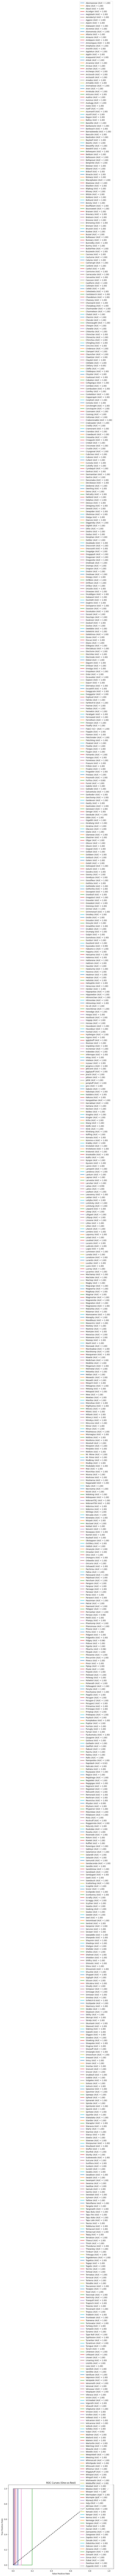

In [ ]:
# ROC Curves
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)
n_classes = len(class_names)

plt.figure(figsize=(10, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    if i in np.unique(y_true):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

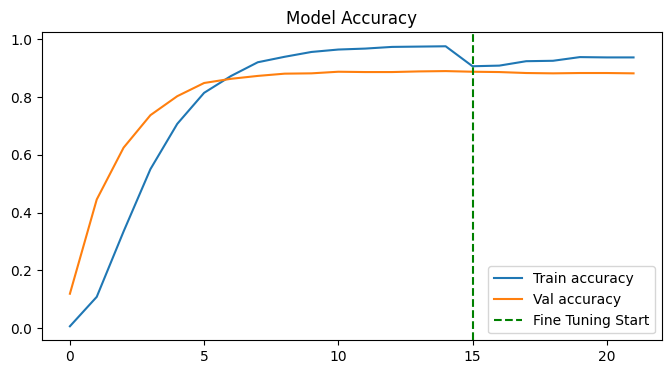

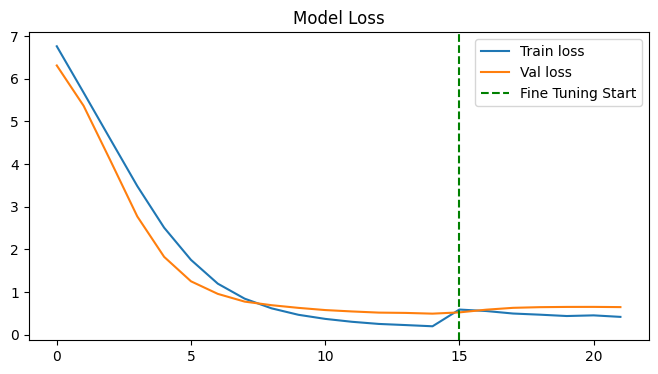

In [ ]:
def plot_history(h1, h2, metric='accuracy'):
    acc = h1.history[metric] + h2.history[metric]
    val_acc = h1.history[f'val_{metric}'] + h2.history[f'val_{metric}']
    plt.figure(figsize=(8, 4))
    plt.plot(acc, label=f'Train {metric}')
    plt.plot(val_acc, label=f'Val {metric}')
    plt.axvline(x=len(h1.history[metric]), color='green', linestyle='--', label='Fine Tuning Start')
    plt.title(f'Model {metric.capitalize()}')
    plt.legend()
    plt.show()

plot_history(history_1, history_2, 'accuracy')
plot_history(history_1, history_2, 'loss')